## Simple CDO Analysis: The Problem

A bank has placed 10 speculative grade corporate bonds in a CDO it is looking to sell. Each bond is 5 years in duration, makes quarterly coupon payments at an annual coupon rate of 6%, and the annual default probability is 4%. The LGD is 60% for all bonds. The market YTM on the bonds is 9%, and the risk-free interest rate is 1% per year. The “correlation” between any two bonds’ default dates is equal to a constant of 0.20. The bonds’ face values are $10 MM each.

**The CDO**

The structuring group has proposed two PACs for the CDO. The Class A tranche has an initial notional value of 20 MM and a coupon rate of 2% per year. The Class B tranche has a notional value of $10 MM and a coupon rate of 4% per year. The bank will retain the residuals as equity.

**The Waterfall**

The waterfall is as follows: Class A is paid first from available cash flows, and then Class B is paid. The residual goes to the bank. There are no carry-forwards, all cash flows are distributed as earned.

In [1]:
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

import seaborn as sns
sns.set()

## Simulation Default Dates

We will use poisson process to simulate the default dates for the corporate bonds.
![simu default date](./pic/poisson_formula.png)
![simu default date](./pic/poisson_process.png)

**The simulation steps are:**

- 1 generate normally distributed random number
- 2 remove the sample mean
- 3 computer the covariance matrix of sample
- 4 remove the correlation and match the moments for the sample

Here we build *DefaultDateSimulator* class to handle the default dates simulation process. 


![simu default date](./pic/simu_default_date.png)

In [2]:
class DefaultDateSimulator:
    def __init__(self,
                 sim_size=1000,
                 bond_size=10,
                 frequency=4,
                 default_probability=0.04,
                 target_correlation=0.2):

        self.sim_size = sim_size
        self.bond_size = bond_size
        self.frequency = frequency
        self.default_probability = default_probability
        self.target_correlation = target_correlation

        self.target_correlation_matrix = self._build_correlation_matrix()
        self.target_correlation_matrix_cholesky = self._cholesky_decomposition(self.target_correlation_matrix)

        self.clean_normals = None
        self.correlated_geometric = None

    def _build_correlation_matrix(self):
        mat = np.ones((self.bond_size, self.bond_size)) * self.target_correlation
        for i in range(self.bond_size):
            mat[i, i] = 1
        return mat

    def run(self):
        self._get_clean_normals()
        self._get_correlated_possion()

    def _get_clean_normals(self):
        dirty_normals = np.random.normal(0, 1, size=(self.sim_size, self.bond_size))
        # demean
        demean_normals = dirty_normals - dirty_normals.mean(axis=0)
        # moment matching
        cov_normals = np.cov(demean_normals.T)
        cov_normals_cholesky = self._cholesky_decomposition(cov_normals)
        self.clean_normals = np.dot(demean_normals, self._inverse_matrix(cov_normals_cholesky.T))
        self._sanity_check_matrix(self.clean_normals, 'Normals after Moment Matching')

    def _get_correlated_possion(self):
        correlated_normals = np.dot(self.clean_normals, self.target_correlation_matrix_cholesky.T)
        self._sanity_check_matrix(correlated_normals, 'Correlated Normals')
        correlated_uniform = norm.cdf(correlated_normals)
        self.correlated_poisson = -np.log(1 - correlated_uniform) / (self.default_probability / self.frequency)

    def _sanity_check_matrix(self, matrix, text='sanity check'):
        print('----------------------------')
        print(text)
        print('----------------------------')
        print('Matrix Mean:')
        print(matrix.mean(axis=0))
        print('Matrix Covariance:')
        print(np.cov(matrix.T))

    def _inverse_matrix(self, matrix):
        return np.linalg.inv(matrix)

    def _cholesky_decomposition(self, matrix):
        return np.linalg.cholesky(matrix)

----------------------------
Normals after Moment Matching
----------------------------
Matrix Mean:
[-0.  0.  0.  0.  0. -0. -0.  0.  0. -0.]
Matrix Covariance:
[[ 1.  0. -0. -0.  0. -0.  0. -0.  0.  0.]
 [ 0.  1. -0. -0. -0. -0. -0. -0.  0. -0.]
 [-0. -0.  1. -0. -0.  0.  0. -0.  0. -0.]
 [-0. -0. -0.  1.  0. -0. -0. -0. -0.  0.]
 [ 0. -0. -0.  0.  1.  0. -0. -0.  0.  0.]
 [-0. -0.  0. -0.  0.  1.  0.  0. -0.  0.]
 [ 0. -0.  0. -0. -0.  0.  1. -0.  0. -0.]
 [-0. -0. -0. -0. -0.  0. -0.  1. -0. -0.]
 [ 0.  0.  0. -0.  0. -0.  0. -0.  1. -0.]
 [ 0. -0. -0.  0.  0.  0. -0. -0. -0.  1.]]
----------------------------
Correlated Normals
----------------------------
Matrix Mean:
[-0.  0.  0. -0.  0. -0. -0.  0.  0. -0.]
Matrix Covariance:
[[1.  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
 [0.2 1.  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 1.  0.2 0.2 0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 1.  0.2 0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 1.  0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2 1.  0.2 0.2 0.2 0.2

Text(0.5, 1.0, 'Default Dates for Two Bonds')

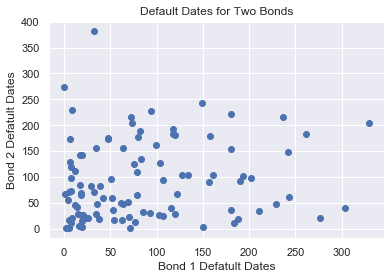

In [3]:
simulator = DefaultDateSimulator(
    sim_size=10000,
    bond_size=10,
    default_probability=0.04,
    target_correlation=0.2)

simulator.run()
sim_default_dates = simulator.correlated_poisson

plt.scatter(sim_default_dates[:100,1], sim_default_dates[:100,2])
plt.xlabel('Bond 1 Defatult Dates')
plt.ylabel('Bond 2 Defatult Dates')
plt.title('Default Dates for Two Bonds')

## Simulate Cash FLows For Each Quarter and Each Class

Here we build *CdoAnalyzer* class to handle the CDO analysis. 

In [4]:
class CdoAnalyzer:
    def __init__(self,
                 default_dates=[],
                 bond_size=10,
                 default_probability=0.04,
                 lgd=0.6,
                 face_value=10000000,
                 coupon_rate=0.06,
                 years=5,
                 frequency=4,
                 risk_free_rate=0.01,
                 notional_A=20000000,
                 notional_B=10000000,
                 coupon_rate_A=0.02,
                 coupon_rate_B=0.04,
                 discount_rate_bond=0.09,
                 discount_rate_A=0.015,
                 discount_rate_B=0.05):

        self.default_dates = default_dates
        self.bond_size = bond_size
        self.default_probability = default_probability
        self.lgd = lgd
        self.face_value = face_value
        self.coupon_rate = coupon_rate
        self.years = years
        self.frequency = frequency
        self.risk_free_rate = risk_free_rate
        self.notional_A = notional_A
        self.notional_B = notional_B
        self.coupon_rate_A = coupon_rate_A
        self.coupon_rate_B = coupon_rate_B
        self.discount_rate_bond = discount_rate_bond
        self.discount_rate_A = discount_rate_A
        self.discount_rate_B = discount_rate_B

        self.portfolio_value = np.nan
        self.periods = self.years * self.frequency
        self.sim_size = len(default_dates)

        self.sim_cashflow = []
        self.sim_result = pd.DataFrame(index=range(self.sim_size),
                                       columns=['classA_default', 'classB_default', 'classA_lgd', 'classB_lgd',
                                                'classA_value', 'classB_value', 'equity_value', 'equity_IRR'])
        self.sim_statistics = {'classA_default_rate': np.nan,
                               'classB_default_rate': np.nan,
                               'classA_lgd': np.nan,
                               'classB_lgd': np.nan,
                               'classA_value': np.nan,
                               'classB_value': np.nan,
                               'equity_value': np.nan,
                               'equity_ROE': np.nan}
        # self._initialize_cashflow()
        self._get_discount_factor()
        self._get_portfolio_value()

        self.notional_equity = self.portfolio_value - self.notional_A - self.notional_B

    def _initialize_cashflow(self):
        bond_cashflow_values = np.ones((self.periods, self.bond_size)) * self.face_value * self.coupon_rate / self.frequency
        bond_cashflow_values[-1, :] += self.face_value
        other_cashflow_values = np.zeros((self.periods, 6))
        self.sim_cashflow = [pd.DataFrame(np.hstack((bond_cashflow_values, other_cashflow_values)),
                                          index=list(range(1, self.periods + 1)),
                                          columns=['bond_' + str(i) for i in range(self.bond_size)] +
                                                  ['aggregated_cf', 'classA_required', 'classA_get', 'classB_required',
                                                   'classB_get', 'equity_get'])
                             ] * self.sim_size

    def _get_discount_factor(self):
        self.discount_factor_bond = (
                    (1 / (1 + self.discount_rate_bond / self.frequency)) * np.ones((self.periods))).cumprod()
        self.discount_factor_A = ((1 / (1 + self.discount_rate_A / self.frequency)) * np.ones((self.periods))).cumprod()
        self.discount_factor_B = ((1 / (1 + self.discount_rate_B / self.frequency)) * np.ones((self.periods))).cumprod()

    def _get_portfolio_value(self):
        payment = self.face_value * self.coupon_rate / self.frequency
        self.portfolio_value = self.bond_size * (payment / (self.discount_rate_bond / self.frequency) * (1 - 1/(1 + self.discount_rate_bond / self.frequency)**self.periods)
                                                 + self.face_value/(1+self.discount_rate_bond/self.frequency)**self.periods)

    def get_default_rate_parameters(self, notionals_A):
        origin_notional_A = self.notional_A
        default_rates_A = []
        for notional in notionals_A:
            self._update_notional_A(notional)
            self.run()
            default_rates_A.append(self.sim_statistics['classA_default_rate'])
        multi_default_rate = pd.DataFrame({'classA_notional': notionals_A,
                                           'classA_default_rate': default_rates_A})

        self._update_notional_A(origin_notional_A)
        self.run()
        return multi_default_rate

    def _update_notional_A(self, notional_A):
        self.notional_A = notional_A
        self.notional_equity = self.portfolio_value - self.notional_A - self.notional_B

    def _update_notional_B(self, notional_B):
        self.notional_B = notional_B
        self.notional_equity = self.portfolio_value - self.notional_A - self.notional_B

    def run(self):
        self._initialize_cashflow()
        self._get_bond_cf()
        self._get_portfolio_cf()
        self._get_class_required_cf()
        self._get_class_get_cf()
        self._get_sim_result()
        self._get_sim_statistics()

    def _get_bond_cf(self):
        for sim_num in range(self.sim_size):
            self.sim_cashflow[sim_num] = self.sim_cashflow[sim_num].fillna(self.face_value * self.coupon_rate / self.frequency)

            for bond_num in range(self.bond_size):
                bond_name = 'bond_' + str(bond_num)
                default_period = math.ceil(self.default_dates[sim_num][bond_num])
                if default_period < self.periods:
                    self.sim_cashflow[sim_num][bond_name].loc[default_period:] = self.sim_cashflow[sim_num][bond_name].loc[default_period:] * (1 - self.lgd)
            self.sim_cashflow[sim_num] = self.sim_cashflow[sim_num].fillna(0)

    def _get_portfolio_cf(self):
        for sim_num in range(self.sim_size):
            self.sim_cashflow[sim_num]['aggregated_cf'] = self.sim_cashflow[sim_num][
                                                        ['bond_' + str(i) for i in range(self.bond_size)]].sum(axis=1)

    def _get_class_required_cf(self):
        for sim_num in range(self.sim_size):
            self.sim_cashflow[sim_num]['classA_required'] = self.notional_A * self.coupon_rate_A \
                                                            / self.frequency
            self.sim_cashflow[sim_num]['classA_required'].iloc[-1] += self.notional_A
            self.sim_cashflow[sim_num]['classB_required'] = self.notional_B * self.coupon_rate_B \
                                                            / self.frequency
            self.sim_cashflow[sim_num]['classB_required'].iloc[-1] += self.notional_B

    def _get_class_get_cf(self):
        for sim_num in range(self.sim_size):
            self.sim_cashflow[sim_num]['classA_get'] = self.sim_cashflow[sim_num][['aggregated_cf', 'classA_required']].min(axis=1)
            self.sim_cashflow[sim_num]['cf_afterA'] = self.sim_cashflow[sim_num]['aggregated_cf'] - self.sim_cashflow[sim_num]['classA_get']
            self.sim_cashflow[sim_num]['classB_get'] = self.sim_cashflow[sim_num][['cf_afterA', 'classB_required']].min(axis=1)
            self.sim_cashflow[sim_num]['equity_get'] = self.sim_cashflow[sim_num]['aggregated_cf'] \
                                                       - self.sim_cashflow[sim_num]['classA_get'] \
                                                       - self.sim_cashflow[sim_num]['classB_get']

    def _get_sim_result(self):
        for sim_num in range(self.sim_size):
            self.sim_result.loc[sim_num]['classA_default'] = sum(abs(self.sim_cashflow[sim_num]['classA_required']
                                                                     - self.sim_cashflow[sim_num]['classA_get'])) != 0
            self.sim_result.loc[sim_num]['classB_default'] = sum(abs(self.sim_cashflow[sim_num]['classB_required']
                                                                     - self.sim_cashflow[sim_num]['classB_get'])) != 0
            self.sim_result.loc[sim_num]['classA_lgd'] = 1 - self.sim_cashflow[sim_num]['classA_get'].sum()\
                                                            / self.sim_cashflow[sim_num]['classA_required'].sum()
            self.sim_result.loc[sim_num]['classB_lgd'] = 1 - self.sim_cashflow[sim_num]['classB_get'].sum() \
                                                            / self.sim_cashflow[sim_num]['classB_required'].sum()
            self.sim_result.loc[sim_num]['classA_value'] = (self.sim_cashflow[sim_num]['classA_get']
                                                            * self.discount_factor_A).sum()
            self.sim_result.loc[sim_num]['classB_value'] = (self.sim_cashflow[sim_num]['classB_get']
                                                          * self.discount_factor_B).sum()
            self.sim_result.loc[sim_num]['equity_value'] = self.portfolio_value \
                                                           - self.sim_result.loc[sim_num]['classA_value'] \
                                                           - self.sim_result.loc[sim_num]['classB_value']

            self.sim_result.loc[sim_num]['equity_IRR'] = np.irr(
                np.hstack((-np.ones((1,)) * self.sim_result.loc[sim_num]['equity_value'],
                           self.sim_cashflow[sim_num]['equity_get'].values))
            ) * self.frequency


    def _get_sim_statistics(self):
        self.sim_statistics['classA_default_rate'] = self.sim_result['classA_default'].mean() / self.years
        self.sim_statistics['classB_default_rate'] = self.sim_result['classB_default'].mean() / self.years
        self.sim_statistics['classA_lgd'] = self.sim_result[self.sim_result['classA_default']]['classA_lgd'].mean()
        self.sim_statistics['classB_lgd'] = self.sim_result[self.sim_result['classB_default']]['classB_lgd'].mean()
        self.sim_statistics['classA_value'] = self.sim_result['classA_value'].mean()
        self.sim_statistics['classB_value'] = self.sim_result['classB_value'].mean()
        self.sim_statistics['equity_value'] = self.sim_result['equity_value'].mean()
        self.sim_statistics['equity_ROE'] = self.sim_result['equity_IRR'].mean()

**Task 1**

Build a simulation model of the aggregate quarterly cash flows of the portfolio, as a function of the quarterly cash flows.

**Task 2**

Apply the waterfall rules to determine the cash flow patterns to each class.

In [5]:
analyzer = CdoAnalyzer(
    default_dates=sim_default_dates,
    bond_size=10,
    default_probability=0.04,
    lgd=0.6,
    face_value=10,
    coupon_rate=0.06,
    years=5,
    frequency=4,
    risk_free_rate=0.01,
    notional_A=23.23,
    notional_B=10,
    coupon_rate_A=0.02,
    coupon_rate_B=0.04,
    discount_rate_bond=0.09,
    discount_rate_A=0.015,
    discount_rate_B=0.05  # hw: 0.05, class:0.03
)
analyzer.run()

D:\programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:166: DeprecationWarning: numpy.irr is deprecated and will be removed from NumPy 1.20. Use numpy_financial.irr instead (https://pypi.org/project/numpy-financial/).


For one case, we can check the computation procedures.

In [6]:
sim_cashflow_2 = analyzer.sim_cashflow[2]
sim_cashflow_2.iloc[:15,:]

,bond_0,bond_1,bond_2,bond_3,bond_4,bond_5,bond_6,bond_7,bond_8,bond_9,aggregated_cf,classA_required,classA_get,classB_required,classB_get,equity_get,cf_afterA
1,0.06,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,1.41,0.11615,0.11615,0.1,0.1,1.19385,1.29385
2,0.06,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,1.41,0.11615,0.11615,0.1,0.1,1.19385,1.29385
3,0.06,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,1.41,0.11615,0.11615,0.1,0.1,1.19385,1.29385
4,0.06,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,1.41,0.11615,0.11615,0.1,0.1,1.19385,1.29385
5,0.06,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,1.41,0.11615,0.11615,0.1,0.1,1.19385,1.29385
6,0.06,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,1.41,0.11615,0.11615,0.1,0.1,1.19385,1.29385
7,0.06,0.15,0.15,0.15,0.15,0.06,0.15,0.15,0.15,0.15,1.32,0.11615,0.11615,0.1,0.1,1.10385,1.20385
8,0.06,0.15,0.15,0.15,0.15,0.06,0.15,0.15,0.15,0.15,1.32,0.11615,0.11615,0.1,0.1,1.10385,1.20385
9,0.06,0.15,0.15,0.15,0.15,0.06,0.15,0.15,0.15,0.15,1.32,0.11615,0.11615,0.1,0.1,1.10385,1.20385
10,0.06,0.15,0.15,0.15,0.15,0.06,0.15,0.15,0.15,0.15,1.32,0.11615,0.11615,0.1,0.1,1.10385,1.20385


## Highest Notional Value of Tranche A

**Task 3**

The target credit rating for the Class A is Moody's Aa. What is the highest notional value of tranche A that will support that rating?

We find that the annual default rate for a Moody's Aa Bond is 0.03%. Therefore, we check the likely tranche A notionals and the corresponding default rates.

![moody](./pic/moody.png)

In [7]:
multi_default_rate = analyzer.get_default_rate_parameters(notionals_A=[50, 52, 52.5, 52.6, 52.7, 53, 55])
multi_default_rate

D:\programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:166: DeprecationWarning: numpy.irr is deprecated and will be removed from NumPy 1.20. Use numpy_financial.irr instead (https://pypi.org/project/numpy-financial/).


,classA_notional,classA_default_rate
0,50.0,0.00018
1,52.0,0.00018
2,52.5,0.00018
3,52.6,0.00078
4,52.7,0.00078
5,53.0,0.00078
6,55.0,0.00078


Text(0, 0.5, 'Default Rate of Tranche A')

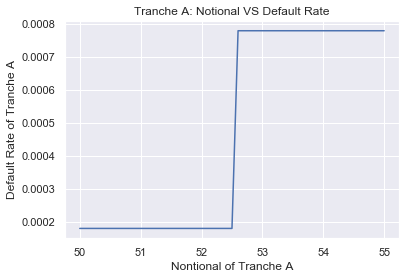

In [8]:
plt.figure()
plt.plot(multi_default_rate['classA_notional'], multi_default_rate['classA_default_rate'])
plt.title('Tranche A: Notional VS Default Rate')
plt.xlabel('Nontional of Tranche A')
plt.ylabel('Default Rate of Tranche A')

Tranche A's notional should be **52.5 MM** which results in a default rate of , making tranche A Moody's Aa rating.

## Compute The Results For Determined Tranche A Notional
**Task 4**

Assume that tranche A is priced to yield 50 bppa over the risk-free rate. Using your new notional value for tranche A in Task 3, keeping the Class B issuance at $10 MM in face value, and the discount rate for B as 4% per year over treasuries, answer the following:
- What is the probability of default for class B and the expected loss given default? (do not discount)
- Value of Class A, B and equity
- ROE for the bank (as equity holder)

**Run Simulation Again**

After update the given class A notional 52.5 MM and class B notional 10 MM, we run the simulation again and have a look at the behavior of each simulation.

In [9]:
analyzer._update_notional_A(52.5)
analyzer._update_notional_B(10)
analyzer.run()
sim_result = analyzer.sim_result
sim_result.head(5)

D:\programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:166: DeprecationWarning: numpy.irr is deprecated and will be removed from NumPy 1.20. Use numpy_financial.irr instead (https://pypi.org/project/numpy-financial/).


,classA_default,classB_default,classA_lgd,classB_lgd,classA_value,classB_value,equity_value,equity_IRR
0,False,False,0,0,53.7622,9.56002,24.705,0.240426
1,False,False,0,0,53.7622,9.56002,24.705,0.240426
2,False,False,0,0,53.7622,9.56002,24.705,0.127382
3,False,False,0,0,53.7622,9.56002,24.705,0.204658
4,False,False,0,0,53.7622,9.56002,24.705,-0.121273


**Combine Simulation Results**

We compute the average value of all simulation results and get the final solution.

In [16]:
sim_stat = analyzer.sim_statistics
print('Class B Default Rate = {}'.format(sim_stat['classB_default_rate']))
print('Expected Class B LGD = {}'.format(sim_stat['classB_lgd']))

sim_result[(sim_result['classA_default']==False) & ((sim_result['classB_default']==False))].iloc[0, :].to_frame()

Class B Default Rate = 0.00218
Expected Class B LGD = 0.5144113149847096


,0
classA_default,False
classB_default,False
classA_lgd,0
classB_lgd,0
classA_value,53.7622
classB_value,9.56002
equity_value,24.705
equity_IRR,0.240426


The default rate of class B is **0.218%**

The expected loss given default of class B is **51.441%**

Value of class A is **53.7622**

Value of class B is **9.560**

Value of equity is **24.705**

ROE for the bank is **24.043%**

## Advantages of CDO Design

**Task 5**

Discuss the reasons why the bank might have done this structure.

- The reasons for making such a structure is to enhance credit. Since the cash flows fulfills the Class A and B at the first place, the bank takes over all rik factor. As the rating mentioned in the project, the Class A and B have high credit rating. Since the CDO cash flow structure hedges the equity investment against short-term liquidity or technical fluctuations in the value of the collateral, the investor would choose CDO as a way of diversification. 
- Secondly, there is a leverage for equity. The leverage is achieved by issuing investment and sub-investment grade debt as term asset-backed securities. 
- Meanwhile, corporate debts are relatively illiquid in the secondary market. CDO is a kind of fixed income securities with high predictability of cash flow, which can meet different investment needs and increase investment income Thus, accompanying with senior tranche and junior tranche, the liquidation of equity tranche increases.
